# Exercise "Lecture 14: Neural Classification"


In this set of exercises, we will use a Recurrent Neural Network to classify BBC news articles into 5 topics. The dataset consists of 2225 documents and 5 categories: business, entertainment, politics, sport, and technology. 


The exercises cover the following points:

* Converting the text in the corpus to vectors of integers (each integer represents a word in the corpus vocabulary)
* Computing some descriptive statistics to identify a sentence length cutoff (sentences with longer lengths will not be considered for training)
* Specifying, training and testing a recurrent neural network 

### Preprocessing (PROVIDED)

We first prepocessed the data to extract X (the input) and Y (the input labels)

In [3]:
import pandas as pd
from sklearn.datasets import load_files


# for reproducibility
random_state = 0 

DATA_DIR = "bbc/"
data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace", random_state=random_state)


df = pd.DataFrame({'news_report': data['data'], 'labels': data['target']})
# add text labels 
df['labels_text'] = df.labels.apply(lambda x: data['target_names'][x])
print(df.shape)
df.head()

(2225, 3)


,news_report,labels,labels_text
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,0,business
1,Halo 2 sells five million copies\n\nMicrosoft ...,4,tech
2,MSPs hear renewed climate warning\n\nClimate c...,2,politics
3,Pavey focuses on indoor success\n\nJo Pavey wi...,3,sport
4,Tories reject rethink on axed MP\n\nSacked MP ...,2,politics


Extracting X (texts) and Y (classes)

In [4]:
texts = df["news_report"]
labels = df["labels"]

n=100
print(texts[n])
print(labels[n])

Spain coach faces racism inquiry

Spain's Football Federation has initiated disciplinary action against national coach Luis Aragones over racist comments about Thierry Henry.

If found guilty Aragones could lose his job or face a fine of about £22,000. The federation had initially declined to take action against Aragones after comments he made during a national team training session in October. But its president Angel Maria Villar changed his mind after a request by Spain's anti-violence commission. Aragones insisted the comments, made to Henry's Arsenal club-mate Jose Antonio Reyes, were meant to motivate the player, and were not intended to be offensive.

"I never intended to offend anyone, and for that reason I have a very easy conscience," he said at the time. "I'm obliged to motivate my players to get the best results. "As part of that job, I use colloquial language, with which we can all understand each other within the framework of the football world. " England's players made a 

### 2 Converting the texts in the corpus to vectors of integers 

#### Exercise 1 -  Convert the corpus to a list of lists of integers

* Define a dictionary tokens2int which maps each distinct token in the corpus to a distinct integer 
(the size of this dictionary is the size of the corpus vocabulary i.e., the number of distinct tokens in the corpus, cf. Python CS)
* Use this dictionary to map each news report to a vector.


**Example**
* Input Texts: ["The woman put the book on the table", "The woman reads"]
* Created vocabulary: {the, woman, put, book, on, table, reads}
* Output Texts: [ [1,2,3,1,4,5,1,6], [1,2,7]]



In [7]:
global_text = list(texts)

# get the vocabulary
voc = set()
import spacy
nlp = spacy.load('en_core_web_sm')

for text in global_text:
    doc = nlp(text)
    for token in doc:
        voc.add(token.text)

print(len(voc))

34731


In [8]:
# convert the vocabulary into a list, so that we fix an order
voc_list = list(voc)

In [9]:
# create a mapping dictionnary from token to index
tokens2int = {w: i for i, w in enumerate(voc_list)}

In [11]:
tokens2int["am"]

32537

In [13]:
# use this mapping to convert texts into lists of integers
texts_as_ints = [[tokens2int[w.text] for w in nlp(text)] for text in global_text]
df["texts_as_ints"] = texts_as_ints

In [14]:
df.head()

,news_report,labels,labels_text,texts_as_ints
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,0,business,"[27237, 28574, 14131, 10250, 20486, 17805, 317..."
1,Halo 2 sells five million copies\n\nMicrosoft ...,4,tech,"[27597, 17213, 10454, 6732, 26691, 31975, 4962..."
2,MSPs hear renewed climate warning\n\nClimate c...,2,politics,"[27016, 26658, 1644, 21692, 5309, 4962, 23464,..."
3,Pavey focuses on indoor success\n\nJo Pavey wi...,3,sport,"[7490, 31371, 8185, 14519, 25407, 4962, 24702,..."
4,Tories reject rethink on axed MP\n\nSacked MP ...,2,politics,"[13999, 32269, 2590, 8185, 11619, 14723, 4962,..."


#### Exercise 2 - Define the reverse int2token mapping and check the token2int and the int2token mappings on an example

* Check that the words have been correctly converted to integer by applying the reverse integer to token mapping
* Print out the vocabulary size 
* Print out the maximum text length 


In [12]:
# define the reverse mapping
int2tokens = {i: w for i, w in enumerate(voc_list)}

In [24]:
# check that the reverse mapping is correct
int_sentence = df.iloc[0].texts_as_ints
print("** Back-conversion:\n", " ".join([int2tokens[i] for i in int_sentence]))
print("\n** Original:\n", df.iloc[0].news_report)

** Back-conversion:
 Tate & Lyle boss bags top award 

 Tate & Lyle 's chief executive has been named European Businessman of the Year by a leading business magazine . 

 Iain Ferguson was awarded the title by US publication Forbes for returning one of the UK 's " venerable " manufacturers to the country 's top 100 companies . The sugar group had been absent from the FTSE 100 for seven years until Mr Ferguson helped it return to growth . Tate 's shares have leapt 55 % this year , boosted by firming sugar prices and sales of its artificial sweeteners . 

 " After years of a sagging stock price and a seven - year hiatus from the FTSE 100 , one of Britain 's venerable manufacturers has returned to the vaunted index , " Forbes said . Mr Ferguson took the helm at the company in 2003 , after spending most of his career at consumer goods giant Unilever . Tate & Lyle , which was an original member of the historic FT-30 index in 1935 , operates more than 41 factories and 20 more additional prod

In [16]:
print("Vocabulary size: ",len(tokens2int))

Vocabulary size:  34731


In [18]:
print("Maximum text length: ", max([len(text) for text in texts_as_ints]))

Maximum text length:  5062


#### Exercise 3 - Compute some statistics to determine which sentences to keep

The maximum sentence size is very large (4432 tokens). Presumably most reports are not that long. Use pandas describe() method and matplotlib to get a better idea of the data distribution in terms of report length.

* Compute the list of report lengths (list of nb of tokens for each report in the BBC news corpus)
* Compute the box plots for report lengths
* Use pandas describe() method to get the descripte statistics (min, max, means, etc.)

In [26]:
df["length"] = df["texts_as_ints"].apply(lambda x: len(x))
df["length"].describe()

count    2225.000000
mean      454.232809
std       277.552961
min       103.000000
25%       292.000000
50%       394.000000
75%       555.000000
max      5062.000000
Name: length, dtype: float64

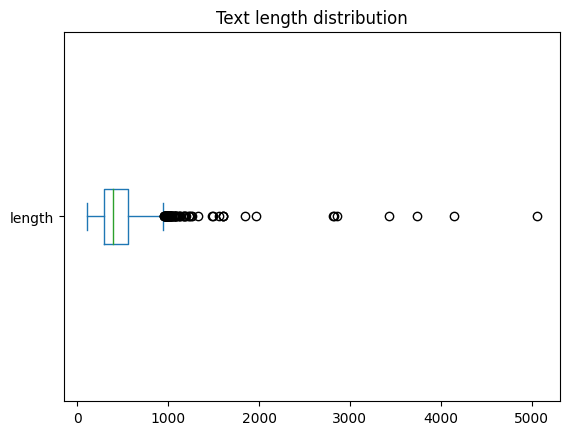

In [32]:
from matplotlib import pyplot as plt

df["length"].plot(kind="box", vert = False)
plt.title("Text length distribution")
plt.show()

There are lots of outliers with very long reports. We see that 555 could be a more reasonable length.

### 2  Classifying with a Recurrent Neural Network

We import some pytorch submodules (PROVIDED)

* torch: functions to create tensors and operations on tensors 
* torch.nn: to specify neural networks
* torch.nn.functional for when we want to define a custom layer for example with a convolution operation layer.
* torch.optim: optimizers for training 

We also need to specify some constants which ensure that the code can run on CPU. The `max_len` constant is important as text whose size exceeds (in number of tokens) that limit will be discarded. We set it to 555 (see next). 

In [33]:
!python -m pip install torch==2.0.0 torchvision torchaudio

     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     --- ------------------------------------ 0.1/1.2 MB 3.2 MB/s eta 0:00:01
     ------ --------------------------------- 0.2/1.2 MB 2.4 MB/s eta 0:00:01
     ----------- ---------------------------- 0.3/1.2 MB 2.6 MB/s eta 0:00:01
     --------------- ------------------------ 0.5/1.2 MB 2.6 MB/s eta 0:00:01
     -------------------- ------------------- 0.6/1.2 MB 2.5 MB/s eta 0:00:01
     ------------------------------ --------- 0.9/1.2 MB 3.3 MB/s eta 0:00:01
     ----------------------------------- ---- 1.1/1.2 MB 3.2 MB/s eta 0:00:01
     ---------------------------------------  1.2/1.2 MB 3.3 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 3.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     ---- ----------------------------------- 0.1/1.2 MB 4.3 MB/s eta 0:00:01
     ------------ --------------------------- 0.4/1.2 MB 4.6 MB/s eta 0:00:01



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Exercise 4 - Creating tensors

To help speed up computation, all data must be converted to tensors. 

* Set the maximum size of text to the 3rd quartile (555)
* Create a tensor of size  (number of texts, maximum size of a text) for X. Call this tensor X. Longer texts will be cut down to maximal size and shorter texts will be padded with `<eos>`. Use torch.zeros method and make sure to specify the components will be of type integer (long attribute in torch)
* Populate this matrix with the integer version of the BBC news report (cf. Exercise 1). Use the torch.LongTensor method. When populating the matrix cut down sentence whose length is above the max length to max length
* Create another tensor of size (numbers of text) and populate it with the list of labels. Call this tensor Y.
* Print out the shape of X and Y . X should be of size (2225, 555) and Y of size (2225,) 

N.B. In practice, it is not necessary to have all the data in a single tensor. In fact, this is inefficient if the texts have varied length. The only constraint is that for a given batch, all sequences have the same size. 

In [66]:
max_length = 555 #3rd quartile of the length distribution
num_texts = len(texts_as_ints)
print(num_texts)

2225


In [67]:
# create tensor X of integers with shape (num_texts, max_length)
X = torch.zeros(num_texts, max_length).long()
print(X.shape)

torch.Size([2225, 555])


In [68]:
# populate X with the data
for i in range(num_texts):
    text_as_ints = texts_as_ints[i]
    length = len(text_as_ints)
    if length <= max_length:
        X[i, :length] = torch.tensor(text_as_ints)
    else:
        X[i, :] = torch.tensor(text_as_ints[:max_length])

print(X.shape)
X

torch.Size([2225, 555])


tensor([[27237, 28574, 14131,  ...,     0,     0,     0],
        [27597, 17213, 10454,  ...,     0,     0,     0],
        [27016, 26658,  1644,  ...,     0,     0,     0],
        ...,
        [20215, 12846,  5490,  ...,     0,     0,     0],
        [ 5669, 18693, 25759,  ..., 21964, 25214, 27757],
        [ 2723, 10978, 10042,  ...,     0,     0,     0]])

In [69]:
Y = torch.LongTensor(labels)
print(Y.shape)

torch.Size([2225])


#### Exercise 5 - Create train and test data

* Split X into two parts, one called X_train which consists of the first 1112 items and the other called X_valid which includes the rest of the data
* Do the same for Y

In [70]:
X_train = X[:1112]
X_valid = X[1112:1334]

print(X_train.shape, X_valid.shape)

torch.Size([1112, 555]) torch.Size([222, 555])


In [71]:
Y_train = Y[:1112]
Y_valid = Y[1112:1334]

print(Y_train.shape, Y_valid.shape)

torch.Size([1112]) torch.Size([222])


#### Create batches with DataLoader (PROVIDED)

pytorch provides a batch generator which shuffles the data. We apply it to train and validation data

In [72]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32
# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

#### Exercise 6 - Define your neural network (PARTIALLY PROVIDED)

We define a network by specifying a subclass of the appropriate pytorch modules. For instance here, as we want to create an RNN we create a subclass of pytorch RNN module. The specification of the network falls into 2 parts. 

In the **init part**, the layers of the network are defined and  their type and shape are specified.  

In the **forward part**, we connect the layers and specify input and output for each layer. 
 
* The hidden state returned by the GRU layer is of size (num_layers * num_directions, batch_size, hidden_size) 
* The input to the decision layer should be of size (batch_size, hidden_size).   

Hence the first 2 dimensions of hidden must be transposed and the tensor redimensioned to (batch_size, hidden_size).

* drop : (num_layers * num_directions, batch_size, hidden_size)
* drop.transpose(0,1): (batch_size, num_layers * num_directions,  hidden_size)
* x.size(0) = batch_size
* drop.transpose(0,1).contiguous.view(x.size(0), -1): (batchsize, hiddensize)

**TODO:** fill in the missing variables (marked by ???)

In [73]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super().__init__()
        
        # Here we define the network layers
        
        # An embedding layer projecting vectors of size vocab_size into embeddings of size embed_size
        # Assigns to each word in the vocabulary an embedding of size embed_size
        self.embed = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_size)
        
        # A recurrent (GRU) layer to process each input token (represented by its embedding)
        # The GRU network takes as input the embedding (of size embed_size) of the current word 
        # and the previous hidden state (of size hidden_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True) 
        
        # Drop out layer for regularisation
        self.dropout = nn.Dropout(0.1)
        
        # Fully connected layer mapping 
        # the last layer maps a hidden state to a vector of size the number of classes
        self.decision = nn.Linear(in_features = hidden_size, out_features = num_classes)
         
    def forward(self, x):
        # Here we say how the layers are connected 
       
        #  for each token in the input, retrieve the corresponding embeddings 
        
        # x = [batch size, input size]
        embed = self.embed(x)
        # embed = [batch size, sent len, emb dim]       
       
        # Run the RNN on the input embeddings
        # output is the sequence of hidden states produced by the RNN
        # hidden is the last hidden state produced
        output, hidden = self.rnn(embed)
        
        # output = [sent len, batch size, hidden size]
        # hidden = [num_layers * num_directions, batch size, hidden_size ]
        
        # Apply dropout (for regularisation)
        drop = self.dropout(hidden)
        
        # drop = [num_layers * num_directions, batch size, hidden_size]   
        
        # Apply the fully connected layer to the output of the dropout
        # Expected input size: [batch_size, input_size]
        # We transpose [num_layers * num_directions, batch size, hidden_size ]
        # to: [batch size, num_layers * num_directions, hidden_size ]
        # And apply view to create an input of the form [batch size, input_size ]
        # (x.size(0) = batch size)
        
        # effectively the same as with drop.squeeze(0)
        return self.decision(drop.view(x.size(0), -1))
    
rnn_model = RNN(vocab_size = len(tokens2int), embed_size = 64, 
                hidden_size = 128, num_classes=len(df.labels.unique()))
device = torch.device('cpu')
rnn_model.to(device)

RNN(
  (embed): Embedding(34731, 64)
  (rnn): GRU(64, 128, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (decision): Linear(in_features=128, out_features=5, bias=True)
)

#### Exercise 7  - Evaluating (PARTIALLY PROVIDED)

We define an evaluation function (called "perf") which computes the average loss on the test/validation dataset and the proportion of correct cases. 

* We use pytorch nn.CrossEntropyLoss() as loss function.
* For each batch returned by the loader, we calculate the scores produced by the model for each class, the loss, the predictions and the loss.
* To block dropout (which should only be used at training time), we use the eval() method. 
* "with torch.no_grad()" temporarily set all the requires_grad flag to false. In practice, this enforces that gradients are not computed (and therefore the weights of the model remain unchanged). 

**TODO:** Modify the function so that it outputs the proportion of correct predictions in addition to the loss. Replace the '??' in the function with the correct variables and/or operations on these variables.


In [74]:
def perf(model, loader):
    # define the loss
    criterion = nn.CrossEntropyLoss()
    # No drop out
    model.eval()
    total_loss, correct, num = 0, 0, 0
    with torch.no_grad():  # No gradient computation, weights remain unchanged
        for x, y in loader:

            # Compute the scores for the instances in the input batch
            y_scores = model(x)
            # Compute the loss
            loss = criterion(y_scores, y)
            # Compute the predictions
            y_pred = torch.max(y_scores, 1)[1] # same as .argmax(dim=1)

            # Update the batch loss
            total_loss += loss.item()
            num += len(y)
            
            # check for match with target 
            # sum Trues to give count of correct predictions
            correct += sum(y_pred == y).item()
    
    return {'loss': total_loss, 'acc': correct/num}

In [75]:
perf(rnn_model, valid_loader)

{'loss': 11.366937398910522, 'acc': 0.15765765765765766}

In [76]:
perf(rnn_model, train_loader)

{'loss': 57.23272728919983, 'acc': 0.1447841726618705}

#### Exercise 8  - Training Loop

Define a function fit(model, epochs) which you will use to train your model

* use the CrossEntropyLoss and the Adam optimizer
* iterates over the epochs and for each epoch:
   - Set the module in training mode (use the train() method). Dropout will be enabled and gradients will be computed. 
   - Initialise the total loss to 0
   - Iterate over each batches returned by train_loader    
     For each batch:   
        - set the gradients to null (optimizer.zero_grad())
        - predicts the batch scores
        - calculate the loss
        - back propagate
        - optimize (adjust the weights)
        - update the total loss
   
**Hint:** Some of these steps are defined in the preceding exercise.

In [80]:
def fit(model, train_loader, epochs):

    # define the loss
    criterion = nn.CrossEntropyLoss()

    # define the optimiser
    optimiser = optim.Adam(model.parameters(), lr=0.001)

    # iterate over epochs    
    for epoch in range(epochs):
        
        # set the model in training mode
        model.train()

        # initialize the total_loss to 0
        total_loss = 0

        # iterate over batches
        for x, y in train_loader:
                
            # reset the gradients
            optimiser.zero_grad()

            # predict the batch scores
            y_scores = model(x)

            # calculate the loss
            loss = criterion(y_scores, y)

            # Compute the gradients (backpropagation)
            loss.backward()

            # Update the weights (optimization)
            optimiser.step()

            # Update the batch loss
            total_loss += loss.item()

        print("Epoch: ", epoch, ", Total loss: ", total_loss)
        print(" - Train: ", perf(model, train_loader))
        print(" - Validation: ", perf(model, valid_loader))

#### Exercise 9 - Training

Use the fit function you just defined to train your model. 
* The loss function on the train and validation set should decrease
* The accuracy on the validation set should improve

In [81]:
# fit the model
fit(rnn_model, epochs = 5)

Epoch:  0 , Total loss:  53.12880790233612
 - Train:  {'loss': 52.14663338661194, 'acc': 0.33902877697841727}
 - Validation:  {'loss': 10.932819604873657, 'acc': 0.2882882882882883}
Epoch:  1 , Total loss:  51.656761169433594
 - Train:  {'loss': 49.99267637729645, 'acc': 0.3489208633093525}
 - Validation:  {'loss': 10.96294367313385, 'acc': 0.28378378378378377}
Epoch:  2 , Total loss:  50.06919348239899
 - Train:  {'loss': 50.053454756736755, 'acc': 0.3902877697841727}
 - Validation:  {'loss': 11.37528145313263, 'acc': 0.26126126126126126}
Epoch:  3 , Total loss:  49.144044399261475
 - Train:  {'loss': 46.89612567424774, 'acc': 0.38758992805755393}
 - Validation:  {'loss': 11.164799571037292, 'acc': 0.2972972972972973}
Epoch:  4 , Total loss:  46.97850060462952
 - Train:  {'loss': 45.50417184829712, 'acc': 0.42356115107913667}
 - Validation:  {'loss': 11.175099611282349, 'acc': 0.2747747747747748}


In [82]:
# evaluate the model on the validation set
perf(rnn_model, valid_loader)

{'loss': 11.175099611282349, 'acc': 0.2747747747747748}

### 3 Classifying with a Convolutional Neural Network (OPTIONAL)

Here below is a CNN model definition. Run it on the data and compare the speed and results with that of the RNN.

In [83]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.1)
        self.decision = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embed = self.embed(x)
        conv = F.relu(self.conv(embed.transpose(1,2)))
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

cnn_model = CNN(vocab_size = len(tokens2int), embed_size = 64, 
                hidden_size = 128, num_classes=len(df.labels.unique()))
cnn_model.to(device)

CNN(
  (embed): Embedding(34731, 64)
  (conv): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.1, inplace=False)
  (decision): Linear(in_features=128, out_features=5, bias=True)
)

In [84]:
fit(cnn_model, train_loader, epochs = 3)

TypeError: fit() got multiple values for argument 'epochs'